In [3]:
# import
import pandas as pd
import numpy as np
from pkg_resources import load_entry_point
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import csv
import time
import psutil
from keras.callbacks import CSVLogger
from datetime import datetime
from packaging import version
from tensorflow.keras.callbacks import TensorBoard
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras import backend as K, regularizers
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow import keras
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import albumentations as A

In [26]:
# dataset training and testing

data_train_dir = '/Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/CK_perio_split/train'
data_test_dir = '/Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/CK_perio_split/test'
data_val_dir = '/Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/CK_perio_split/validation'
data_work_dir = '/Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/workspace/CK+/perio/Perio_CK_model2_2'
data_limiter = 10000
data_image_height = 224
data_image_width = 224
data_autobalance = None
data_autobalance_maximages = 400
data_model_number=2 # 1:'MobileNetV3-small', 2:'MobileNetV3-large', 3:'EfficientNetV2B0', 4:'EfficientNetV2B1', 5:'EfficientNetV2B2', 6:'InceptionResNetV2', 7:'MobileNetV2', 8:'MobileNetV1'
data_batch=33
data_epoch=100
data_ask_epoch=101

data_csv_name='Model2PerioCkEpoch100Batch33'
data_model_name='Model2PerioCkEpoch100Batch33'

In [5]:
def print_in_color(txt_msg,fore_tupple= (0,255,255) ,back_tupple=(0,0,0)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m', end='') 

In [6]:
def plot_label_count (df, plot_title):
    subdir = os.path.join(data_work_dir, plot_title+".png")
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5)) 
        form = {'family': 'serif', 'color': 'blue', 'size': 25} 
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.savefig(subdir,bbox_inches='tight')        
        plt.show()

In [7]:
def check_dataset_size(train_dir):
    classes=sorted(os.listdir(train_dir))
    ftotal=0
    flargest=0
    fsmallest=100000000
    for klass in classes:
        classpath=os.path.join(train_dir,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            fcount=len(flist)
            if fcount>flargest:
                flargest=fcount
                maxclass=klass
            if fcount < fsmallest:
                fsmallest=fcount
                minclass=klass
            ftotal += fcount
    return ftotal, flargest, maxclass, fsmallest, minclass

In [8]:
def make_dataframes(train_dir,test_dir, val_dir, limiter):
    bad_images=[]
    # check what directories exist
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test'] 
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    ht=0 # set initial value of height counter
    wt=0  # set initial value of width counter
    total_good_files=0 # set initial value of total number of good image files counter
    zipdir=zip(names, dirlist)
    for name,d in zipdir: #iterate through the  names and directories
        filepaths=[] # initialize list of filepaths
        labels=[] # initialize list of class labels
        classlist=sorted(os.listdir(d) )   # get a list of all the classes in alphanumeric order   
        for klass in classlist: # iterate through the list of classes
            msg=f'processing images in {name} directory for class {klass}                                                  '
            print(msg, '\r', end='')
            good_file_count=0 # initialize the good_file count for this class
            classpath=os.path.join(d, klass) # define the full path to the class            
            if os.path.isdir(classpath): # ensure we are working with a directory and not a spurious file
                flist=sorted(os.listdir(classpath)) # make a list of all the files for this class
                if limiter != None: # check if a limiter value was specified that determmine how many files to use in any class
                    if limiter <len(flist): # if there are more files than the value of limiter than randomly sample a limiter number of files
                        flist=np.random.choice(flist, limiter, replace=False)                        
                for f in flist:
                    fpath=os.path.join(classpath,f) # create the full path to the image file
                    index=f.rfind('.')
                    ext=f[index+1:].lower() # the the file's extension
                    if ext not in ['jpg', 'jpeg', 'tiff', 'png', 'bmp'] :   # make sure the file extension is one that works with Keras                     
                        bad_images.append(fpath) # if not a proper extension store the filepath in the bad images list
                    else:                    
                        try: # check if image files are defective if so do not include in dataframe
                            img=cv2.imread(fpath)
                            h=img.shape[0]
                            w=img.shape[1]
                            ht +=h # add images height and width to the counters
                            wt += w                    
                            good_file_count +=1   
                            total_good_files +=1
                            filepaths.append(fpath) # append the filepath to the list of valid filepaths
                            # Unique code just for tomato dataset to shorten the class name remove this code for general use
                            # split=klass.split('__')# delete leading tomato part of class label
                            # label=split[1]
                            # labels.append(label) # append the file's class label to the labels list
                            labels.append(klass)  # uncomment this line for use on general datasets

                        except:
                            bad_images.append(fpath) # if the image file is defective add the filepath to the list of bad images
        print('')
        Fseries=pd.Series(filepaths, name='filepaths') # make a pandas series for the filenames and labels lists
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) # make a dataframe with columns filepaths and labels
        # depending on which directory we are iterating through create dataframes
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None: # create train_df, test_df and valid_df from df
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None: # create just a train_df and test_df 
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            elif val_dir == None:  # create a train_df and a valid_df                          
                pdf=df                
                train_df,valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else:
                train_df= df # test and valid dataframes exists so train_df is just df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)    
    # calculate the average image height and with 
    have=int(ht/total_good_files)
    wave=int(wt/total_good_files)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    if len(bad_images) == 0:
        print_in_color('All image files were properly processed and used in the dataframes')
    else:
        print_in_color(f'the are {len(bad_images)} bad image files and {total_good_files} proper image files in the dataset')
        for f in bad_images:
            print (f)                       
    plot_title='Images per Label in train set'
    plot_label_count (train_df,  plot_title)
    return train_df, test_df, valid_df, classes, class_count, max(counts), min(counts), have, wave

In [9]:
def trim(df, max_samples, min_samples, column):
    # column specifies which column of the dataframe to use, typically this is the labels column
    # df is typically train_df
    df=df.copy()
    classes=df[column].unique() # get the classes in df
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)   # creates a set of  dataframes that only contains rows that have the class label  
    trimmed_df = pd.DataFrame(columns = df.columns) # create an empty dataframe with columns filepaths, labels    
    for label in df[column].unique(): # iterate through each class label
        group=groups.get_group(label) # get the dataframe associate with the label
        count=len(group) # determine how many files are in the dataframe   
        if count > max_samples: # if there more files in the dataframe sample it so the sampled files has only n rows
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0) # add the sampled files to the trimmed_df dataframe
        else:
            if count>=min_samples: # if the dataframe has more than the minimum number of files include it in the dataset
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples and so will have less classes in it
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

In [10]:
def balance(df, n,column, working_dir, img_size):    
    def get_augmented_image(image): # given an image this function returns an augmented image
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        # transform= A.Compose([
        #     A.HorizontalFlip(p=.5),
        #     A.Rotate(limit=30, p=.25),
        #     A.RandomBrightnessContrast(p=.5),
        #     A.RandomGamma(p=.5),
        #     A.RandomCrop(width=width, height=height, p=.25) 
        # ]) 
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=5, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5)
        ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        msg=f'augmenting images in train set  for class {label}                                              '
        print(msg, '\r', end='')        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label:25s}'
            for i in range(delta):                
                j= i % sample_count # need this because we may have to go through the image list several times to get the needed number
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('')
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))    
    return df 

In [11]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size, modnum):
    if modnum == 6:
        gen=ImageDataGenerator(preprocessing_function= tf.keras.applications.inception_resnet_v2.preprocess_input)
    else:
        gen=ImageDataGenerator(width_shift_range=0.0, height_shift_range=0.0, zoom_range=0.0,) 
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels    
    return train_gen, test_gen, valid_gen, test_steps, class_count

In [12]:
def show_image_samples(gen, modnum ):
    subdir = os.path.join(data_work_dir, 'example.png')
    msg='Below are some example training images'
    print_in_color(msg)
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        if modnum == 6:
            image=(images[i]+1)/2
        else:
            image=images[i] /255        
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.savefig(subdir,bbox_inches='tight')
    plt.show()

In [13]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
def make_model(img_size,class_count, lr, modnum):  
    img_shape=(img_size[0], img_size[1], 3)
    if modnum ==1:
        base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg= 'created MobileNet V3  small model'
    elif modnum == 2:
        base_model=tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='created MobileNetV3 large model'
    elif modnum == 3:        
        base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B0 model'         
    elif modnum == 4:
        base_model=tf.keras.applications.EfficientNetV2B1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNetV2 B1 model'
    elif modnum == 5:
        base_model=tf.keras.applications.EfficientNetV2B2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNetV2 B2 model'    
    elif modnum == 6:
        tf.keras.applications.inception_resnet_v2.preprocess_input
        base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max',classifier_activation=None ) 
        msg='Created InceptionResNetV2 model' 
    elif modnum == 7:
        base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg= 'created MobileNet V2 model'
    elif modnum == 8:
        base_model=tf.keras.applications.MobileNet(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg= 'created MobileNet V1 model'
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

In [15]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, batches, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1        
        self.dwell= dwell
        self.factor=factor
        self.header=True
        self.batches=batches
    
    def on_train_begin(self, logs=None): # this runs on the beginning of training 
        msg1 =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to\n'
        msg2='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
        print_in_color(msg1 + msg2)
        if self.dwell:
            msg='learning rate will be automatically adjusted during training'
            print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
   
    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()
    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}- accuracy=  {3:5.3f} - loss: {4:8.5f}          '.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.header == True:
            msg = '{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}\n'
            msg1=msg.format('Epoch', 'Train', 'Train', 'Valid', 'Valid','V_Loss %', 'Learning','Next LR' ,'Duration in')
            msg='{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}'
            msg2=msg.format(' ', 'Loss', 'Accuracy', 'Loss', 'Accuracy','Improvement', 'Rate', 'Rate', '  Seconds') 
            print_in_color (msg1 + msg2)
            self.header=False
        ep_end = time.time()
        duration = ep_end - self.ep_start        
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100            
        else:
            pimprov=0.0             
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1 
            new_lr=lr
            msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
            msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)         
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased                     
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'                 
                msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration) 
                print_in_color(msg, (255,255,0))                
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights                 
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                if ans=='' :
                    ans=10
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.header=True
                    self.ask_epoch += int(ans)
                    msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                    print_in_color(msg) # cyan foreground
                    if self.dwell==False:
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                        print_in_color(msg) # cyan foreground
                        ans=input(' ')
                        if ans =='':
                            msg=f'keeping current LR of {lr:7.5f}'
                            print_in_color(msg) # cyan foreground
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            msg=f' changing LR to {ans}'
                            print_in_color(msg) # cyan foreground

In [16]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return

In [17]:
def save_history_to_csv(history,csvpath):
    trdict=history.history 
    df=pd.DataFrame() 
    df['Epoch']=list(np.arange(1, len(trdict['loss']) + 1 ))
    keys=list(trdict.keys())     
    for key in keys:
        data=list(trdict[key])        
        df[key]=data   
    df.to_csv(csvpath, index=False)

In [18]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score

In [19]:
def save_model(model,subject, classes, img_size, f1score, working_dir):    
    name=f'{subject}-{str(len(classes))}-({str(img_size[0])}X{str(img_size[1])})-{f1score:5.2f}.h5'    
    model_save_loc=os.path.join(working_dir, name)
    try:
        model.save(model_save_loc)        
        msg= f'model was saved as {model_save_loc}'
        print_in_color(msg, (0,255,255),(0,0,0))
    except:
        msg='model can not be saved due to tensorflow 2.10.0 or higher. Bug involving use of EfficientNet Models'        
        print_in_color(msg, (0,255,255), (0,0,0)) # cyan foreground

In [20]:
def run(working_dir= None,train_dir=None, test_dir=None, valid_dir=None,start=True):
    if start:
        msg='Setting on this run \n'
        msg+=f'data_train_dir : {data_train_dir} \n'
        msg+=f'data_test_dir : {data_test_dir} \n'
        msg+=f'data_val_dir : {data_val_dir} \n'
        msg+=f'data_work_dir : {data_work_dir} \n'
        msg+=f'data_limiter : {data_limiter} \n'
        msg+=f'data_image_height : {data_image_height} \n'
        msg+=f'data_image_width : {data_image_width} \n'
        msg+=f'data_autobalance : {data_autobalance} \n'
        msg+=f'data_autobalance_maximages : {data_autobalance_maximages} \n'
        msg+=f'data_model_number : {data_model_number} \n'
        msg+=f'data_batch : {data_batch} \n'
        msg+=f'data_epoch : {data_epoch} \n'
        msg+=f'data_ask_epoch : {data_ask_epoch} \n'
        msg+=f'data_csv_name : {data_csv_name} \n'
        msg+=f'data_model_name : {data_model_name} \n'
        print_in_color(msg)


        if working_dir == None :
            msg='enter the full path to the working directory where data will be stored.'
            print_in_color(msg)
            working_dir=input(' ')
        
        if train_dir == None :
            msg='Enter the full path to the train directory'
            print_in_color(msg)
            train_dir =input(' ')
        
        if valid_dir == None :
            msg = 'Enter the full path to the validation directory. If there is no validation directory press enter'
            print_in_color(msg)
            ans=input(' ')
            if ans == '':
                valid_dir=None
            else:
                valid_dir=ans
        
        if test_dir == None :
            msg = 'Enter the full path to the test directory. If there is no test directory press enter'
            print_in_color(msg)
            ans=input(' ')
            if ans == '':
                test_dir=None
            else:
                test_dir=ans
                                                      
    ftotal, flargest, maxclass , fsmallest, minclass= check_dataset_size(train_dir) # get info on training data
    msg1= f'the train directory contains {ftotal} files, class {maxclass} has the most images of {flargest} files\n'
    msg2= f'class {minclass} contains the least number of images of {fsmallest} files\n'
    msg3= f'NOTE if the value of most images is the same as the value of least images the dataset is balanced\n'
    msg4='When dealing with very large data sets to save time you may not want to read in all the image files\n'
    msg5 ='to limit the maximum number of image files in any class you can enter an integer limiter value'
    msg=msg1 +msg2 + msg3 + msg4 + msg5
    print_in_color(msg) # print the training data information for the user
    msg = 'input a limiter integer value to limit max number of images in a class, for no limit hit enter (1000)'
    print_in_color(msg)
    # limiter=input(' ')
    # if limiter == '':
    #     limiter = None
    #     msg='dataset will be processed as is with no limiter'
    #     print_in_color(msg)
    # else:
    #     limiter=int(limiter)
    #     msg=f'images will be limited to a maximum of {limiter} images in each class'
    #     print_in_color(msg) 
    limiter = data_limiter
    # create train, test and valid data frames
    train_df, test_df, valid_df, classes, class_count, max_samples, min_samples, have, wave=make_dataframes(train_dir,test_dir, valid_dir, limiter)

    msg=f'the average height of training images is {have} and average width is {wave}\n  enter the image height to be used to train the model'            
    print_in_color(msg)
    if data_image_height == None :
        img_height=int(input(' '))
    else :
        img_height = data_image_height
        msg=f'height = {data_image_height} \n'            
        print_in_color(msg)
    
    if data_image_width == None :
        msg=' Enter the image width to be used to train the model' 
        print_in_color(msg)
        img_width=int(input(' '))
    else :
        img_width = data_image_width
        msg=f'width = {data_image_width} \n'            
        print_in_color(msg)


    img_size=(img_height, img_width)
    msg=f'model will be trained with image shape of  ( {img_height}, {img_width} ) \n'    
    print_in_color(msg)
    
    # determine if user wants to balance the training dataframe
    msg=' enter A  to auto balance the train set or enter or hit enter to leave train set unchanged  '
    print_in_color(msg)
    if data_autobalance == None:
        ans=input(' ')
    else:
        ans=data_autobalance
        msg=f' answer {data_autobalance} \n'
        print_in_color(msg)
    
    if ans == 'A' or ans =='a':
        msg='enter the number of images you want to have in each class of the train data set'
        print_in_color(msg)
        if data_autobalance_maximages == None :
            max_images=int(input(' '))  
        else :
            max_images=data_autobalance_maximages
            msg=f'number of images {data_autobalance_maximages} \n'
            print_in_color(msg)
        train_df, classes, class_count=trim(train_df, max_images, min_samples, 'labels') # trim the dataset for max images in a class
        train_df=balance(train_df, max_images, 'labels', working_dir, img_size) # balance the training data with augmented images   
        plot_title='Images per Label after Auto Balance of train data set'
        plot_label_count(train_df,  plot_title)  # plot the number of images in each class of the training set        
    else:        
        msg=f'training data set will be used as is '
        print_in_color (msg)  
    
    
    classes=list(train_df['labels'].unique())
    class_count = len(classes)
    

    if data_batch == None:
        msg='enter the desired batch size or press enter to use the default batch size of 20  '
        print_in_color(msg)
        ans=input(' ')
        if ans =='':
            bs=20
        else:
            bs=int(ans)
    else:
        bs=data_batch
        msg=f' batch {data_batch}  '
        print_in_color(msg)

    # make the train, test and valid data generators    
    print ('select a model number from the list below ',flush=True)
    print ('{0:^9s}{1:^20s}'.format('Model No', 'Model Type'), flush=True)
    models=['MobileNetV3-small', 'MobileNetV3-large', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', ' InceptionResNetV2','MobileNetV2','MobileNetV1',]
    #parameters=[' 1.0 M', '3.3 M', '6.3 M', '7.3 M','9.1 M', '54.7 M']
    for i in range(0,8):
        msg='{0:^9s}{1:^20s}'.format(str(i+1),models[i])
        print (msg)
    if data_model_number == None :
        modnum=int(input(" "))
    else:
        modnum=data_model_number
        msg=f'modul choose {data_model_number}  \n'
        print_in_color(msg)
    
    lr=.001
    model=make_model(img_size,class_count, lr, modnum)
    msg1='enter the number of epochs to run initially. After these epochs complete you can enter H to halt training\n'
    msg2='or enter an integer for how many more epochs to run then be asked again'
    print(msg1 + msg2)
    if data_ask_epoch == None :
        ask_epoch=int(input(' ')) 
    else:
        ask_epoch=data_ask_epoch
        msg=f'ask epoch {data_ask_epoch}  \n'
        print_in_color(msg)
       
    batches=int(len(train_df)/bs)

    # instantiate the custom callback
    epochs=data_epoch
    ask=LR_ASK(model, epochs=epochs,  ask_epoch=ask_epoch, batches=batches) # instantiate the custom callback
    callbacks=[ask]    

    # make the train, test and valid data generators
    train_gen, test_gen, valid_gen, test_steps, class_count= make_gens(bs, 'labels', train_df, test_df, valid_df, img_size, modnum)
    show_image_samples(train_gen, modnum ) # show some sample training images 
    
    msg = f'total train_gen : {train_gen.n}'
    print_in_color(msg)
    msg = f'total test_gen : {test_gen.n}'
    print_in_color(msg)
    msg = f'total valid_gen : {valid_gen.n}'
    print_in_color(msg)

    # train the model
    history=model.fit(x=train_gen,   epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model
    
    tr_plot(history) # plot training data
    msg='To save the training data to a csv file enter the name for the csv file or press enter to not save the data'
    print_in_color(msg)
    if data_csv_name == None :
        ans=input(' ')
    else:
        ans=data_csv_name
        msg=f'csv name {data_csv_name}'
        print_in_color(msg)

    if ans !='': # save the training data to a csv file history.csv in working directory
        csvpath=os.path.join(working_dir, ans + '.csv')
        save_history_to_csv(history,csvpath)
        msg=f'training data saved to {csvpath}'
        print_in_color(msg)
    
    print_in_color('classes-----')
    print(list(test_gen.class_indices.keys()))
    # make predictions on the test set, create classification report and confusion matrix
    f1score=predictor(model,test_gen) # do predictions on test set and generate reports 

    # save the model
    msg=f'your trained model will be saved to directory {working_dir} enter a subject for the saved model'
    print_in_color(msg)
    if data_model_name == None :
        subject=input(' ')
    else:
        subject=data_model_name
        msg=f'save model name {data_model_name}'
        print_in_color(msg)
    
    save_model(model,subject, classes, img_size, f1score, working_dir) # save the model to the working directory
    msg='model save nomenclature is directory/subject-number of classes- (img_height, img_width)- F1score.h5'
    print_in_color(msg) 

    # remove the aug directory from the working directory
    if os.path.isdir(os.path.join(working_dir, 'aug')):
        shutil.rmtree(os.path.join(working_dir, 'aug')) #remove the augmentation directory it is no longer needed
    
    return working_dir,train_dir, test_dir, valid_dir

Setting on this run 
data_train_dir : /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/CK_perio_split/train 
data_test_dir : /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/CK_perio_split/test 
data_val_dir : /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/CK_perio_split/validation 
data_work_dir : /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/workspace/CK+/perio/Perio_CK_model2_2 
data_limiter : 10000 
data_image_height : 224 
data_image_width : 224 
data_autobalance : None 
data_autobalance_maximages : 400 
data_model_number : 2 
data_batch : 33 
data_epoch : 100 
data_ask_epoch : 101 
data_csv_name : Model2PerioCkEpoch100Batch33 
data_model_name : Model2PerioCkEpoch100Batch33 

the train directory contains 3360 files, class anger has the most images of 420 files
class anger contains the least number of images of 420 files
NOTE if the value of most images is the same as the value of least images the dataset is balanced
When dealing with very large data sets to save time you may not want to 

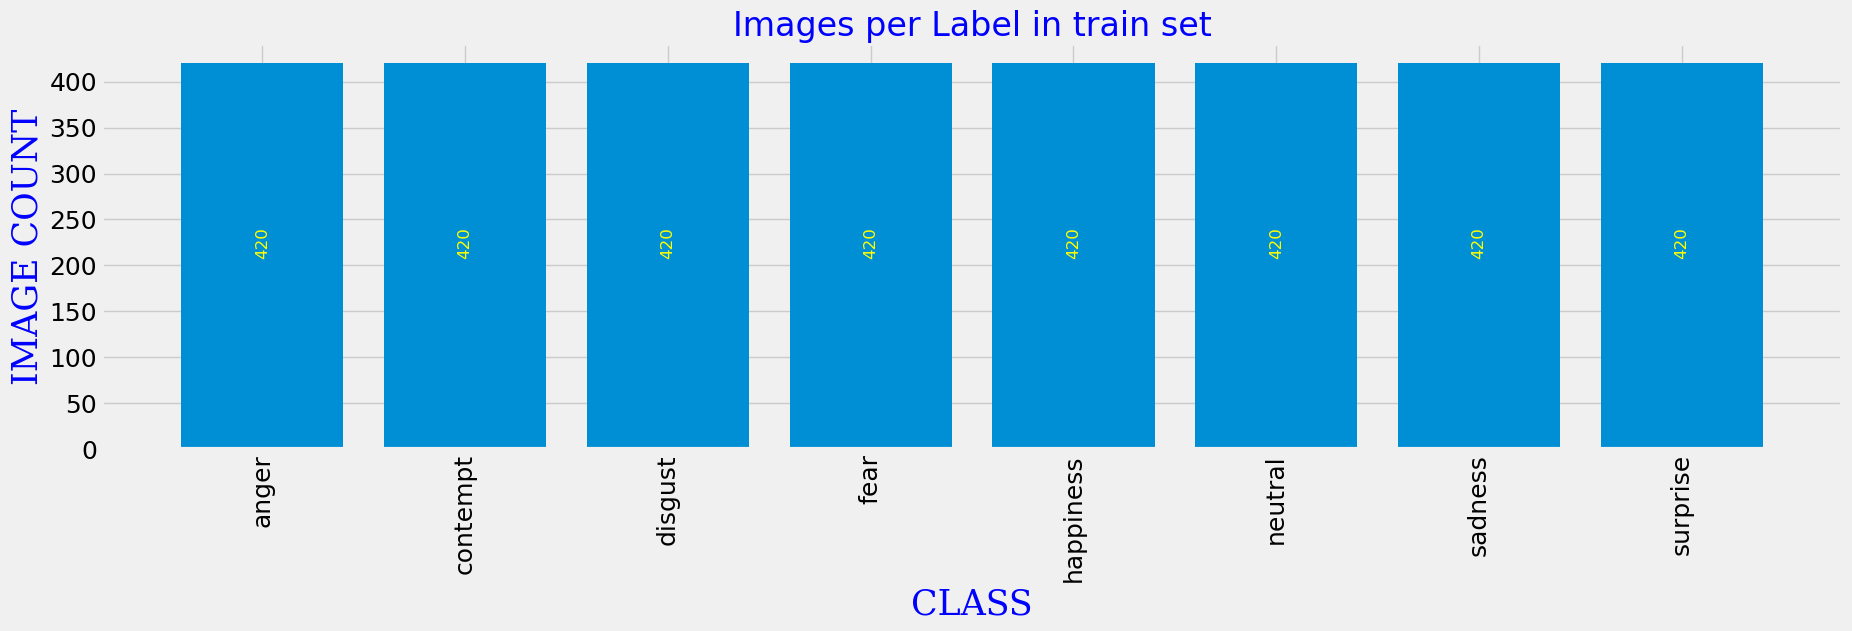

the average height of training images is 104 and average width is 202
  enter the image height to be used to train the model
height = 224 

width = 224 

model will be trained with image shape of  ( 224, 224 ) 

 enter A  to auto balance the train set or enter or hit enter to leave train set unchanged  
training data set will be used as is 
 batch 33  
select a model number from the list below 
Model No      Model Type     
    1     MobileNetV3-small  
    2     MobileNetV3-large  
    3      EfficientNetV2B0  
    4      EfficientNetV2B1  
    5      EfficientNetV2B2  
    6      InceptionResNetV2 
    7        MobileNetV2     
    8        MobileNetV1     
modul choose 2  



created MobileNetV3 large model with initial learning rate set to 0.001
enter the number of epochs to run initially. After these epochs complete you can enter H to halt training
or enter an integer for how many more epochs to run then be asked again
ask epoch 101  

Found 3360 validated image filenames belonging to 8 classes.               for train generator 
Found 720 validated image filenames belonging to 8 classes.            for valid generator 
Found 720 validated image filenames belonging to 8 classes.            for test generator 
Below are some example training images


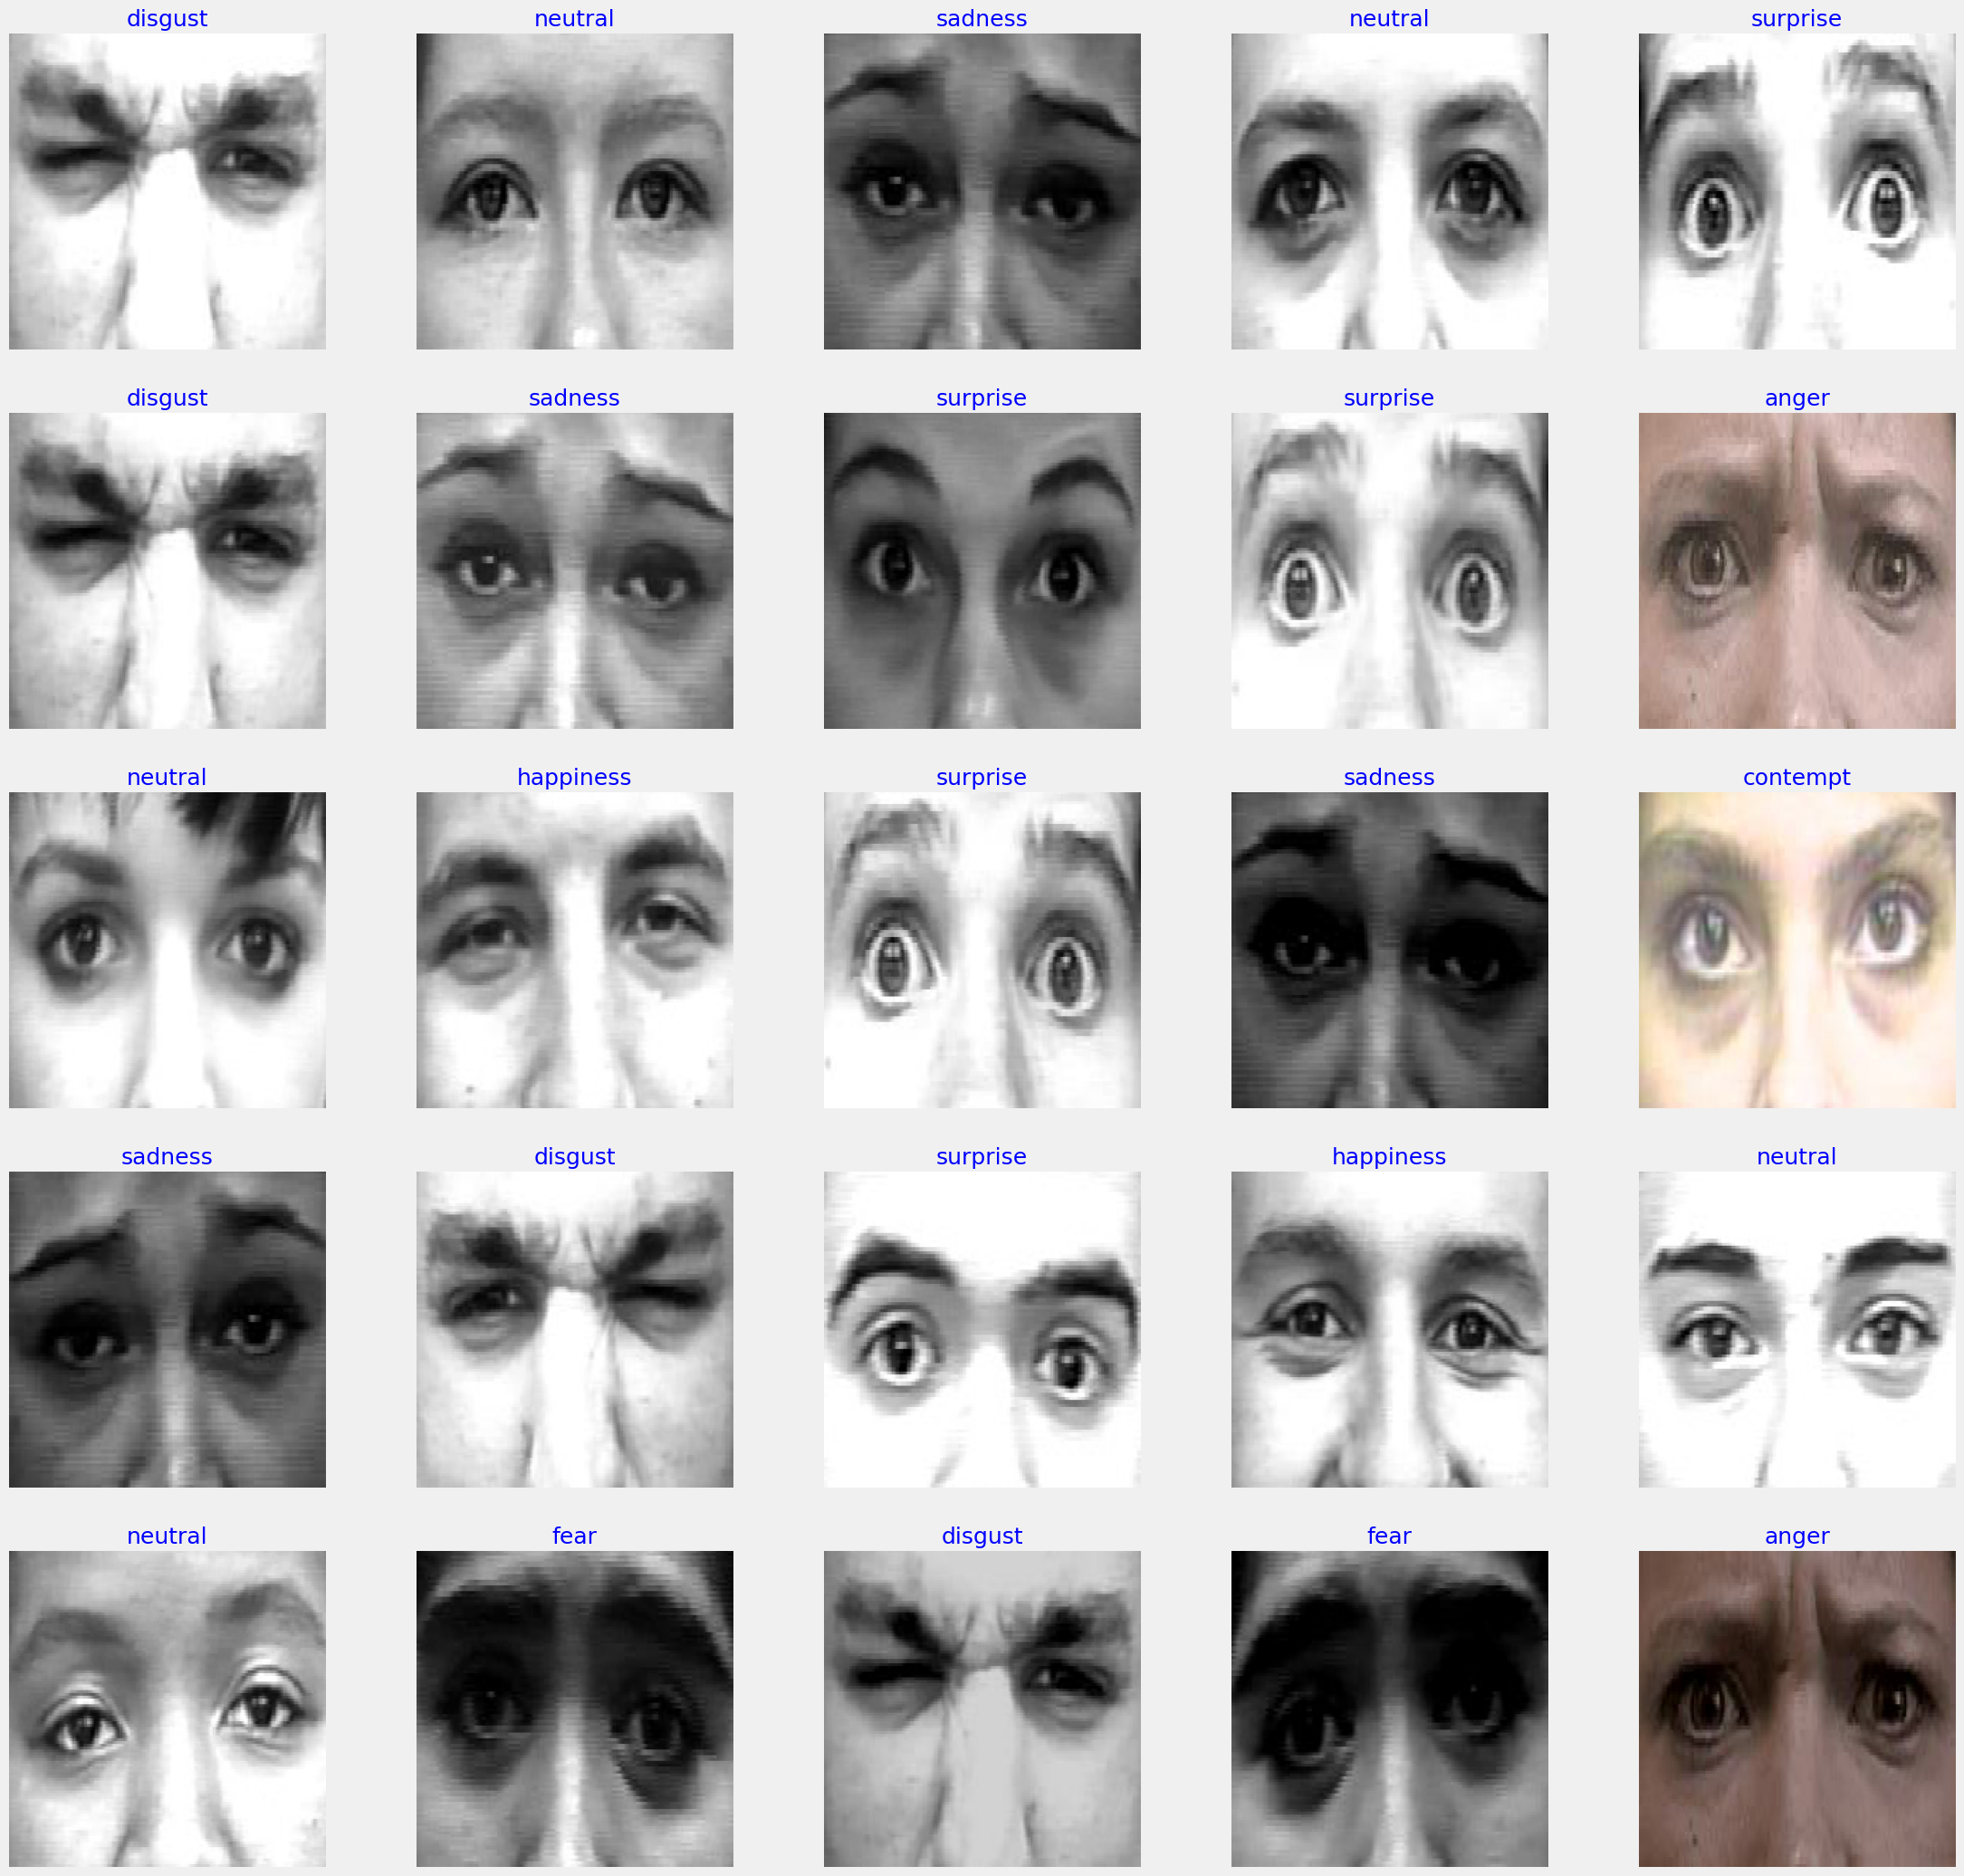

total train_gen : 3360
total test_gen : 720
total valid_gen : 720
Training will proceed until epoch 101 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training


2024-09-08 18:56:08.074052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2024-09-08 18:57:22.593351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
   1    6.1562    91.79   6.2379    54.03       0.00      0.001000    0.001000     78.49     
   2    3.9959    96.40   4.3635    60.14       30.05     0.001000    0.001000     73.05     
   3    2.7304    97.98   3.1708    61.11       27.33     0.001000    0.001000     72.17     
   4    1.8873    98.63   2.3852    62.50       24.77     0.001000    0.001000     72.12     
   5    1.3200    99.08   1.8309    69.17       23.24     0.001000    0.001000     72.37     
   6    0.9327    99.46   1.3825    76.25       24.49     0.001000    0.001000     72.34     
   7    0.6745    99.73   1.1038    77.92       20.16     0.001000    0.001000     71.72     
   8    0.5070    99.82   1.0366    77.22       6.09      0.001000    0.001000     71.44     
   9    0.3906    99.94   0.8041    85.28       22.43     0.

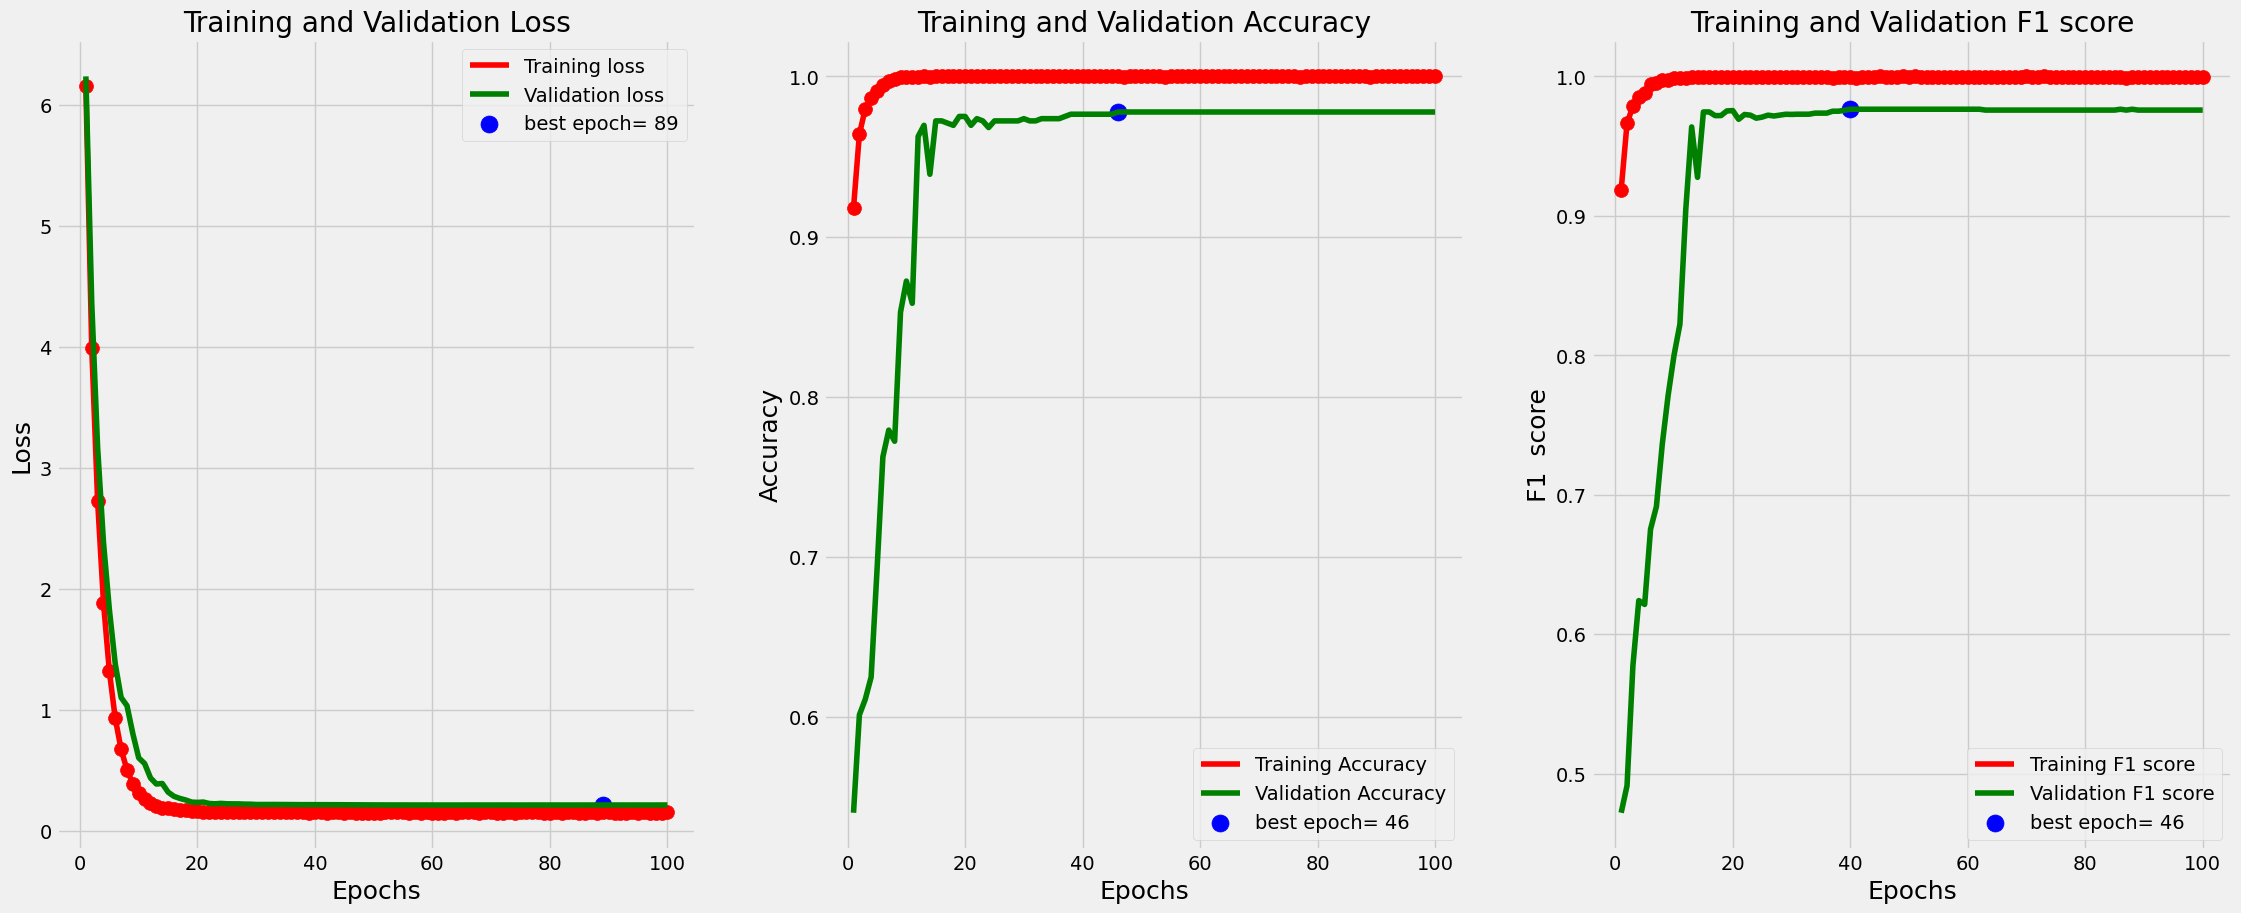

To save the training data to a csv file enter the name for the csv file or press enter to not save the data
csv name Model2PerioCkEpoch100Batch33
training data saved to /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/workspace/CK+/perio/Perio_CK_model2_2/Model2PerioCkEpoch100Batch33.csv
classes-----
['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


2024-09-08 20:58:29.734171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 4s 337ms/step
There were 24 errors in 720 tests for an accuracy of  96.67 and an F1 score of  96.73


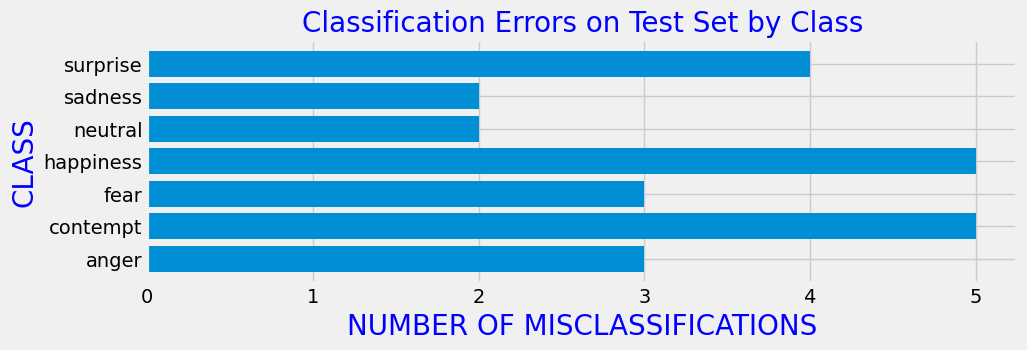

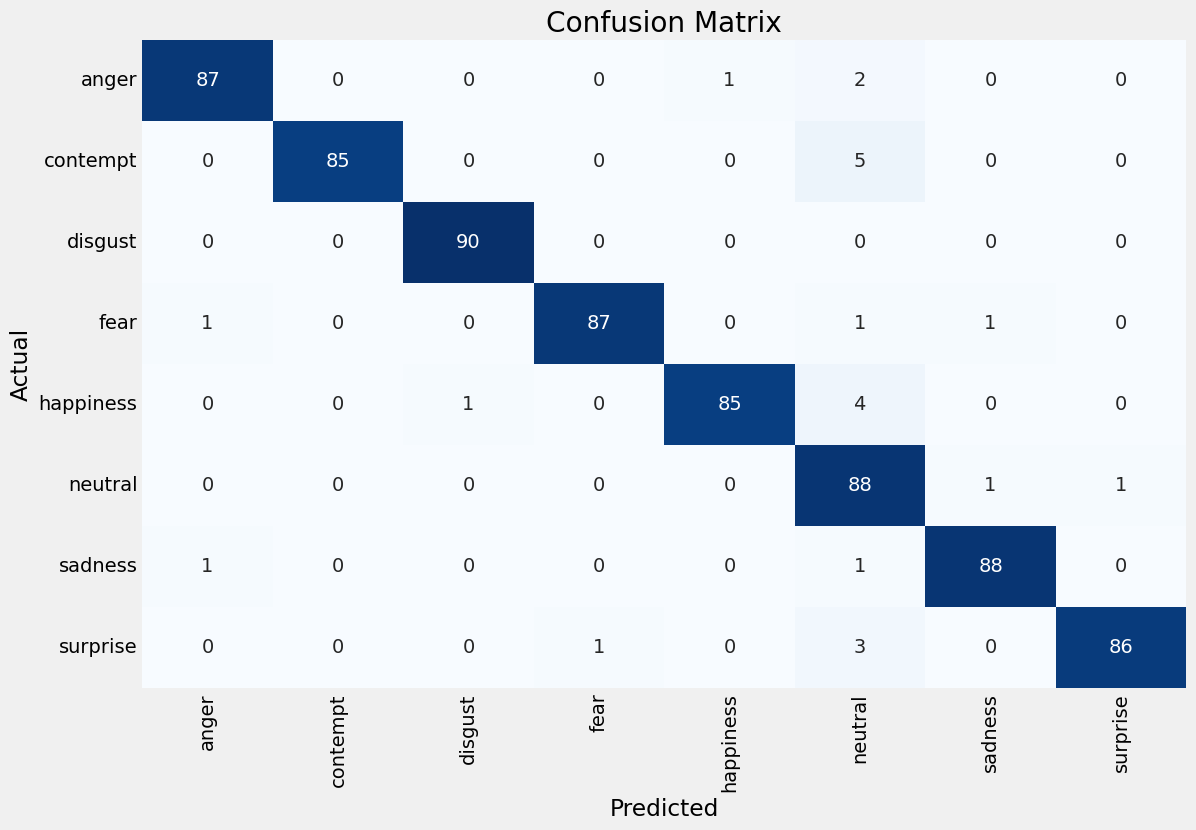

Classification Report:
----------------------
               precision    recall  f1-score   support

       anger     0.9775    0.9667    0.9721        90
    contempt     1.0000    0.9444    0.9714        90
     disgust     0.9890    1.0000    0.9945        90
        fear     0.9886    0.9667    0.9775        90
   happiness     0.9884    0.9444    0.9659        90
     neutral     0.8462    0.9778    0.9072        90
     sadness     0.9778    0.9778    0.9778        90
    surprise     0.9885    0.9556    0.9718        90

    accuracy                         0.9667       720
   macro avg     0.9695    0.9667    0.9673       720
weighted avg     0.9695    0.9667    0.9673       720

your trained model will be saved to directory /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/workspace/CK+/perio/Perio_CK_model2_2 enter a subject for the saved model
save model name Model2PerioCkEpoch100Batch33
model was saved as /Volumes/DiskFile/Kuliah/tesis_code/ImageCrop/workspace/CK+/perio/Perio_

In [27]:
working_dir,train_dir, test_dir, valid_dir=run(working_dir=data_work_dir, train_dir=data_train_dir, test_dir=data_test_dir, valid_dir=data_val_dir, start=True) # run the classifier
stop = False
while stop == False:
    msg='enter R to rerun the classifier or press enter to quit  '
    print_in_color(msg)
    ans=input(' ')
    if ans == 'R' or ans == 'r':
        msg='press Enter to us original director values '
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            run(working_dir,train_dir=train_dir, test_dir=test_dir, valid_dir=valid_dir, start=False ) 
        else:
            run(True)
    else:
        stop = True
        print_in_color ('process commpleted')